In [1]:
import get_data as gd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import Asset as a
import numpy as np
import random
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [2]:
NUMBER_OF_GENERATION = 5
POPULATION_SIZE = 300
MUTATION_PROBABILITY = 0.2
HIGHEST_WINDOWSIZE = 150
LOWEST_WINDOWSIZE = 8
HIGHEST_HIGHTHRESHOLD = 90
LOWEST_HIGHRESHOLD = 60
HIGHEST_LOWTHRESHOLD = 50
LOWEST_LOWTHRESHOLD = 10
MUTATION_HIGH = 1.3
MUTATION_LOW = 0.7

In [3]:
def create_population(size):
    population = []
    # generate population by random parameters(genes)
    for _ in range(size):
        windowsize = random.randint(LOWEST_WINDOWSIZE, HIGHEST_WINDOWSIZE)
        highthreshold = random.uniform(LOWEST_HIGHRESHOLD, HIGHEST_HIGHTHRESHOLD)
        lowthreshold = random.uniform(LOWEST_LOWTHRESHOLD, HIGHEST_LOWTHRESHOLD)
        individual = (windowsize, highthreshold, lowthreshold)
        population.append(individual)
    return population

In [4]:
def apply_strategy(data, individual):
    windowsize, highthreshold, lowthreshold = individual
    rsi = RSIIndicator(data["close"], window=windowsize)
    data["rsi"] = rsi.rsi()
    btc = np.asarray(data["close"])
    asset = a.Asset()
    in_position = False
    money_progress = []
    
    for i in range(len(data) - 1):
        if not in_position and data["rsi"].iloc[i] < lowthreshold:
            asset.buy(btc[i + 1])
            in_position = True
        elif in_position and data["rsi"].iloc[i] > highthreshold:
            asset.sell(btc[i + 1])
            in_position = False

        money_progress.append(asset.money + asset.coin * btc[i + 1])

    if in_position:
        asset.sell(btc[-1])

    money_progress.append(asset.money)

    return money_progress

def calculate_fitness(data, individual):
    money_progress = apply_strategy(data, individual)
    fitness = money_progress[-1] - 100
    return max(fitness, 0)

In [5]:
def roulette_wheel_selection(population, fitness):
    total_fitness = sum(fitness)
    if total_fitness == 0:
        raise ValueError("The total fitness is 0, please try to run the program again.")
    probabilities = [f / total_fitness for f in fitness]
    selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=probabilities)
    return [population[i] for i in selected_indices]

In [6]:
def crossover(parents):
    child1, child2 = parents
    crossover_point = random.randint(1, 2)
    child1 = child1[:crossover_point] + child2[crossover_point:]
    child2 = child2[:crossover_point] + child1[crossover_point:]
    return child1, child2

In [7]:
def mutation(child):
    mutation_prob = MUTATION_PROBABILITY
    mutated_gene_index = random.randint(0, 2)
    mutation_factor = random.uniform(MUTATION_LOW, MUTATION_HIGH)
    
    child = list(child)
    if random.random() < mutation_prob:
        child[mutated_gene_index] *= mutation_factor
        if mutated_gene_index == 0:
            child[mutated_gene_index] = max(min(HIGHEST_WINDOWSIZE, int(child[mutated_gene_index])), LOWEST_WINDOWSIZE)
        elif mutated_gene_index == 1:
            child[mutated_gene_index] = max(min(HIGHEST_HIGHTHRESHOLD, child[mutated_gene_index]), LOWEST_HIGHRESHOLD)
        else:
            child[mutated_gene_index] = max(min(HIGHEST_LOWTHRESHOLD, child[mutated_gene_index]), LOWEST_LOWTHRESHOLD)

    return tuple(child)

In [8]:
def genetic_algorithm(data):
    population = create_population(POPULATION_SIZE)

    for generation in range(NUMBER_OF_GENERATION):
        fitness = [calculate_fitness(data, individual) for individual in population]
        new_population = []

        print(f"Generation {generation + 1}: Top 10 individuals and their fitness:")
        top_individuals = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)[:10]
        for individual, fit in top_individuals:
            print(f"Individual {individual} - Fitness: {fit:.2f}")

        while len(new_population) < POPULATION_SIZE:
            parents = roulette_wheel_selection(population, fitness)
            child1, child2 = crossover(parents)
            child1 = mutation(child1)
            child2 = mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
    
    return top_individuals

In [9]:
df_data = gd.grab_data()
top_individuals = genetic_algorithm(df_data)

Generation 1: Top 10 individuals and their fitness:
Individual (60, 60.40848621681343, 43.245764032560835) - Fitness: 42.15
Individual (35, 71.82616500139301, 31.655292418904438) - Fitness: 36.75
Individual (139, 87.69727915805326, 42.70707344163683) - Fitness: 36.75
Individual (37, 87.47740766777446, 31.94286061424385) - Fitness: 36.75
Individual (101, 77.25740953649364, 41.47396842757777) - Fitness: 36.41
Individual (19, 87.57319647841113, 24.766089635901118) - Fitness: 36.41
Individual (108, 70.02193633147706, 41.661006071603396) - Fitness: 36.41
Individual (58, 80.54790287541212, 37.38275877259215) - Fitness: 36.41
Individual (57, 65.61553260975819, 37.61637831137379) - Fitness: 36.41
Individual (131, 81.93632515880063, 42.52030847918076) - Fitness: 36.41
Generation 2: Top 10 individuals and their fitness:
Individual (70, 60.40848621681343, 43.245764032560835) - Fitness: 53.57
Individual (60, 60.40848621681343, 42.263129878392355) - Fitness: 47.16
Individual (60, 60.40848621681343,

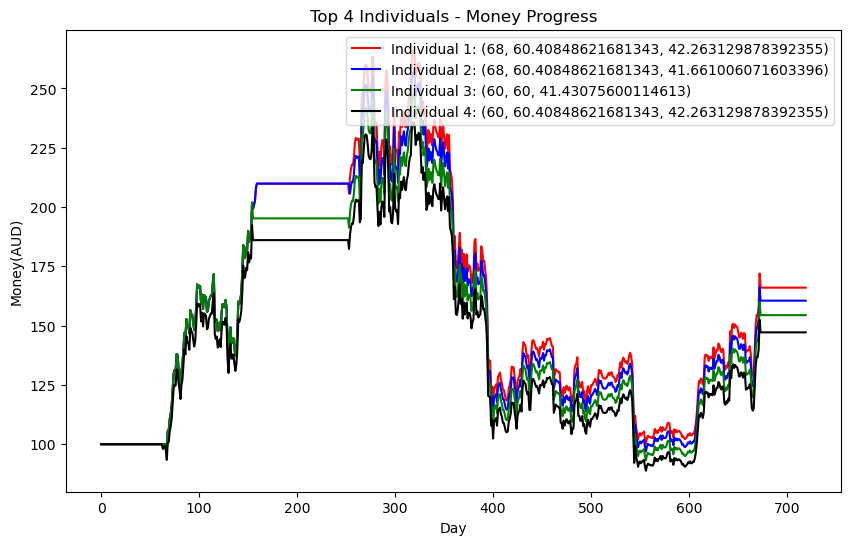

In [10]:
color_list = ['r', 'b', 'g', 'k']
plt.figure(figsize=(10, 6))
for idx, (individual, fit) in enumerate(top_individuals[:4]):
    days = range(len(df_data))
    money_progress = apply_strategy(df_data, individual)
    plt.plot(days, money_progress, color=color_list[idx], label=f"Individual {idx + 1}: {individual}")
plt.legend()
plt.title("Top 4 Individuals - Money Progress")
plt.xlabel("Day")
plt.ylabel("Money(AUD)")
plt.savefig("figure/Top4IndividualsMoneyProgress.png")
plt.show()